In [1]:
import sys
import os
import shutil

_module_path = os.path.abspath("../../")
print(_module_path)
sys.path.append(_module_path)

import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calibration_libs.ccalibration import CCameraCalibration
from calibration_libs.utils import get_chess_corners, get_chess_corners_world, img_to_world_by_dis, world_to_img_l, vis_disparity, toOpen3dCloud, depth2xyzmap
import imageio
import open3d as o3d

c:\Users\86994\Desktop\camera_kit
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
images_path =  os.path.abspath('../calibration/images_640x480')
# 标定板参数
chessSize=[11, 8] # col, row, 长边设置为col, 短边row , col作为x轴， row作为y轴
chessCellLen=20 # 单位 mm
#相机标定类
mycc = CCameraCalibration()  #初始化
mycc.set_calibration_images(images_path, 15, 480, 1280, size=chessSize, length=chessCellLen) #设置标定图像的路径和图片数量
mycc.stereo_calibration(True, reversal=False) #进行双目立体标定，得到内参矩阵、畸变系数、重映射矩阵map、重投影矩阵Q等
mycc.print_p()

['WIN_20251207_14_54_12_Pro.jpg', 'WIN_20251207_14_54_42_Pro.jpg', 'WIN_20251207_14_54_48_Pro.jpg', 'WIN_20251207_14_54_55_Pro.jpg', 'WIN_20251207_14_55_08_Pro.jpg', 'WIN_20251207_14_55_13_Pro.jpg', 'WIN_20251207_14_55_20_Pro.jpg', 'WIN_20251207_14_55_26_Pro.jpg', 'WIN_20251207_14_55_45_Pro.jpg', 'WIN_20251207_14_55_53_Pro.jpg', 'WIN_20251207_14_56_02_Pro.jpg', 'WIN_20251207_14_56_07_Pro.jpg', 'WIN_20251207_14_56_32_Pro.jpg', 'WIN_20251207_14_56_40_Pro.jpg', 'WIN_20251207_14_56_44_Pro.jpg', 'WIN_20251207_14_56_48_Pro.jpg', 'WIN_20251207_14_57_01_Pro.jpg', 'WIN_20251207_14_57_06_Pro.jpg', 'WIN_20251207_14_57_11_Pro.jpg', 'WIN_20251207_14_57_16_Pro.jpg']
you have calibrated !
左图对应相机的内参..................................
[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]

右图对应相机的内参..................................
[[338.19616913   0.         279.11848074]
 [  0.         338.04469341 231.75555723]
 [  0.           

In [3]:
def preprocess_image(img, size=(640, 480)):
    """
    输入: RGB 0-255
    最终 shape = (1,3,480,640)
    """
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

    img = np.transpose(img, (2, 0, 1))      # HWC → CHW
    img = np.expand_dims(img, axis=0)       # CHW → BCHW
    return img

In [15]:
onnx_path = "./onnx_models/S2M2_S_640_480_v2_torch24.onnx"
# onnx_path = r"C:\Users\86994\Desktop\pretrain_weights_s2m2\onnx_save\S2M2_XL_640_480_v2_torch24.onnx"

sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])

input_name = [input.name for input in sess.get_inputs()]
output_name = [output.name for output in sess.get_outputs()]
print(f"onnx_input_name:{input_name}")
print(f"onnx_output_name:{output_name}")

onnx_input_name:['input_left', 'input_right']
onnx_output_name:['output_disp', 'output_occ', 'output_conf']


图像形状: (480, 1280, 3)


Text(0.5, 1.0, 'Remap')

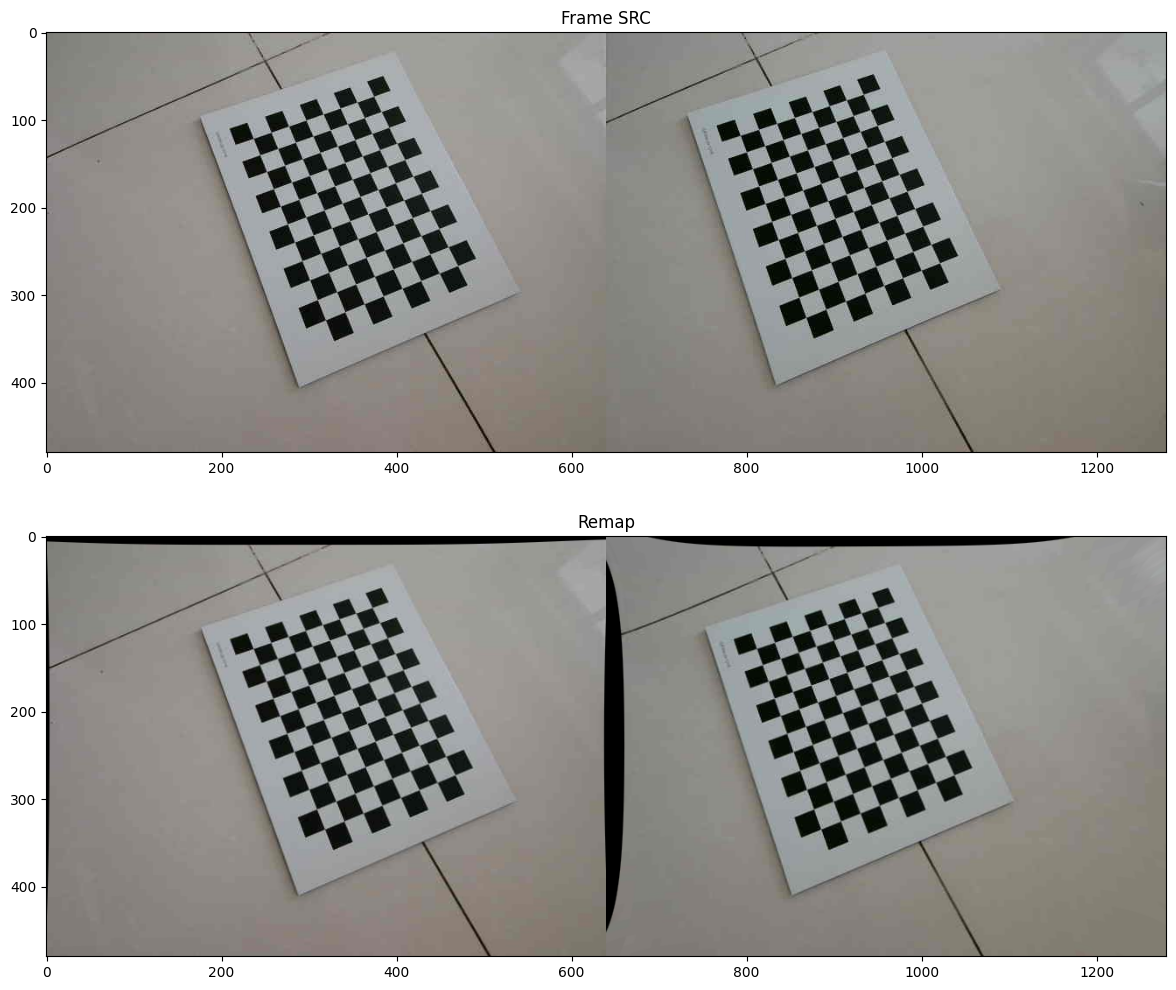

In [16]:

# 立体校正
img_path = '../calibration/images_640x480/WIN_20251207_14_54_12_Pro.jpg'
# img_path = r"C:\Users\86994\Pictures\Camera Roll\WIN_20251212_22_25_10_Pro.jpg"

img_src = cv2.imread(img_path)
print("图像形状:", img_src.shape)
_height, _width, _c = img_src.shape
left_src = img_src[:, 0: _width//2] #拆分左右图像
right_src = img_src[:, _width//2:]

#立体校正
left_remap = cv2.remap(left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
right_remap = cv2.remap(right_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
img_remap =  cv2.hconcat([left_remap, right_remap]) #合并校正后图像

left_remap_orig = cv2.cvtColor(left_remap, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Frame SRC")   # 左图标题

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")   # 左图标题

In [17]:
left_input = preprocess_image(left_remap)
right_input = preprocess_image(right_remap)
print(left_input.shape, left_input.max())

(1, 3, 480, 640) 212


In [18]:
import time
t0 = time.time()
outputs = sess.run([output_name[0], output_name[1], output_name[2]],
                        {input_name[0]: left_input,
                        input_name[1]: right_input})

print("time cost: ", time.time()-t0)
print(f"onnx_output shape: {outputs[1].shape}")

pred_disp, pred_occ, pred_conf = outputs
pred_disp = np.squeeze(pred_disp)
pred_occ = np.squeeze(pred_occ)
pred_conf = np.squeeze(pred_conf)

print(f"pred_disp info-> shape:{pred_disp.shape}, max:{pred_disp.max()}, min:{pred_disp.min()} ")
print(f"pred_occ info->  shape:{pred_occ.shape}, max:{pred_occ.max()}, min:{pred_occ.min()} ")
print(f"pred_conf info-> shape:{pred_conf.shape}, max:{pred_conf.max()}, min:{pred_conf.min()} ")


time cost:  1.8296804428100586
onnx_output shape: (1, 1, 480, 640)
pred_disp info-> shape:(480, 640), max:79.19438171386719, min:56.65086364746094 
pred_occ info->  shape:(480, 640), max:1.000000238418579, min:0.0 
pred_conf info-> shape:(480, 640), max:1.000000238418579, min:0.9971815943717957 


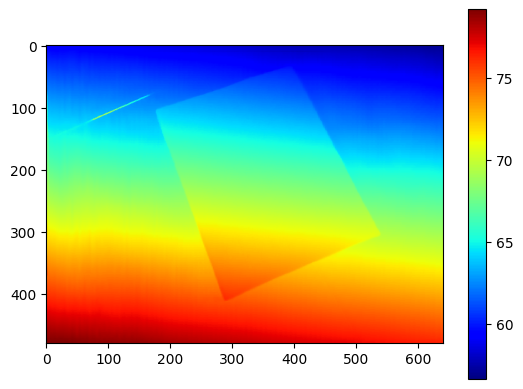

In [19]:
disp = pred_disp
plt.imshow(disp, cmap='jet')
plt.colorbar()
plt.show()

In [20]:
out_dir = f'./test_outputs/'
os.makedirs(out_dir, exist_ok=True)

In [21]:
np.save(os.path.join(out_dir, 'disp.npy'), disp)
vis = vis_disparity(disp)
vis = np.concatenate([left_remap_orig, vis], axis=1)
imageio.imwrite(os.path.join(out_dir, 'vis.png'), vis)
print(f"Output saved to {out_dir}")

Output saved to ./test_outputs/


In [22]:
K = mycc._leftParameters['cameraMatrix']
baseline = 0.06 # 单位 m
print(K)

[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]


In [23]:
depth = K[0,0]*baseline/disp # K[0][0] = f 焦距
np.save(f'{out_dir}/depth_meter.npy', depth)

In [24]:
xyz_map = depth2xyzmap(depth, K)
pcd = toOpen3dCloud(xyz_map.reshape(-1,3), left_remap_orig.reshape(-1,3))
z_far = 20
keep_mask = (np.asarray(pcd.points)[:,2]>0) & (np.asarray(pcd.points)[:,2]<=z_far)
keep_ids = np.arange(len(np.asarray(pcd.points)))[keep_mask]
pcd = pcd.select_by_index(keep_ids)
o3d.io.write_point_cloud(f'{out_dir}/cloud.ply', pcd)
print(f"PCL saved to {out_dir}")

PCL saved to ./test_outputs/


In [25]:
# denoise_nb_points', type=int, default=30, help='number of points to consider for radius outlier removal')
# denoise_cloud', type=int, default=1, help='whether to denoise the point cloud')
# denoise_radius', type=float, default=0.03, help='radius to use for outlier removal')

denoise_cloud = 1
denoise_nb_points = 5
denoise_radius = 0.05

if denoise_cloud:
    print("[Optional step] denoise point cloud...")
    cl, ind = pcd.remove_radius_outlier(nb_points=denoise_nb_points, radius=denoise_radius)
    inlier_cloud = pcd.select_by_index(ind)
    o3d.io.write_point_cloud(f'{out_dir}/cloud_denoise.ply', inlier_cloud)
    pcd = inlier_cloud

print("Visualizing point cloud. Press ESC to exit.")
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.get_render_option().point_size = 1.0
vis.get_render_option().background_color = np.array([0.5, 0.5, 0.5])
vis.run()
vis.destroy_window()


[Optional step] denoise point cloud...
Visualizing point cloud. Press ESC to exit.
